<a href="https://colab.research.google.com/github/rimchehade/AudioNoiseRemovalSystem/blob/main/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Audio Noise Removal System Project**

2025, Rick Azzi - Rim Chehade - Karen Timani

---

**Objective:**

The objective of this project is to develop an Audio Noise Removal System using deep learning techniques. The goal is to train a model that can effectively denoise speech audio recordings, preserving the clarity and intelligibility of the original signal while minimizing background noise. We utilize SEGAN (Speech Enhancement GAN) for its ability to perform end-to-end speech enhancement using a generative adversarial approach.

**Dataset Descricption:**

This project uses the 28spk "datashare" dataset, which contains paired noisy and clean speech recordings from 28 different speakers. Each sample is in WAV format and recorded at a high-quality 48,000 Hz sampling rate. The dataset includes both the original clean version and a version with added background noise, making it ideal for supervised speech enhancement tasks.


# Import Libraries

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import soundfile as sf
from tqdm import tqdm
import IPython.display as ipd
import gc
import torch

# Uploading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Dataset

clean_testset_wav.zip	      noisy_trainset_28spk_wav.zip
clean_trainset_28spk_wav.zip  testset_txt.zip
noisy_testset_wav.zip	      trainset_28spk_txt.zip


In [ ]:
!unzip "/content/drive/MyDrive/Dataset/noisy_trainset_28spk_wav.zip" -d "/content/dataset"
!unzip "/content/drive/MyDrive/Dataset/clean_trainset_28spk_wav.zip" -d "/content/dataset"

!unzip "/content/drive/MyDrive/Dataset/noisy_testset_wav.zip" -d "/content/dataset"
!unzip "/content/drive/MyDrive/Dataset/clean_testset_wav.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/clean_trainset_28spk_wav/p273_410.wav  
  inflating: /content/dataset/clean_trainset_28spk_wav/p273_411.wav  
  inflating: /content/dataset/clean_trainset_28spk_wav/p273_412.wav  
  inflating: /content/dataset/clean_trainset_28spk_wav/p273_413.wav  
  inflating: /content/dataset/clean_trainset_28spk_wav/p273_414.wav  
  inflating: /content/dataset/clean_trainset_28spk_wav/p273_415.wav  
  inflating: /content/dataset/clean_trainset_28spk_wav/p273_416.wav  
  inflating: /content/dataset/clean_trainset_28spk_wav/p273_417.wav  
  inflating: /content/dataset/clean_trainset_28spk_wav/p273_418.wav  
  inflating: /content/dataset/clean_trainset_28spk_wav/p273_419.wav  
  inflating: /content/dataset/clean_trainset_28spk_wav/p273_420.wav  
  inflating: /content/dataset/clean_trainset_28spk_wav/p273_421.wav  
  inflating: /content/dataset/clean_trainset_28spk_wav/p273_422.wav  
  inflating: /content/dataset/clean_tra

# Exploratory Data Analysis (EDA)

**Validating that each noisy audio file has a matching clean version**

In [ ]:
noisy_dir = "/content/dataset/noisy_trainset_28spk_wav"
clean_dir =  "/content/dataset/clean_trainset_28spk_wav"

noisy_files = sorted([os.path.splitext(f)[0] for f in os.listdir(noisy_dir) if f.endswith('.wav')])
clean_files = sorted([os.path.splitext(f)[0] for f in os.listdir(clean_dir) if f.endswith('.wav')])

missing_in_clean = [f for f in noisy_files if f not in clean_files]
missing_in_noisy = [f for f in clean_files if f not in noisy_files]

if not missing_in_clean and not missing_in_noisy:
    print("✅ All files have matching counterparts.")
else:
    print("⚠️ Mismatches found:")
    if missing_in_clean:
        print("No matching clean file for:", missing_in_clean)
    if missing_in_noisy:
        print("No matching noisy file for:", missing_in_noisy)

✅ All files have matching counterparts.


**Checking our dataset's files length**

In [ ]:
dataset_path="/content/dataset"

noisy_trainset_files = os.listdir("/content/dataset/noisy_trainset_28spk_wav")
clean_trainset_files = os.listdir("/content/dataset/clean_trainset_28spk_wav")

noisy_testset_files = os.listdir("/content/dataset/noisy_testset_wav")
clean_testset_files = os.listdir("/content/dataset/clean_testset_wav")


print("noisy trainset file length", len(noisy_trainset_files))
print("clean trainset file length", len(clean_trainset_files))

print("noisy testset file length", len(noisy_testset_files))
print("clean testset file length", len(clean_testset_files))


noisy trainset file length 11572
clean trainset file length 11572
noisy testset file length 824
clean testset file length 824


**Checking the properties of an audio file in the dataset**

In [ ]:
noisy_path = os.path.join(dataset_path, "noisy_trainset_28spk_wav")

audio_path = os.path.join(noisy_path, os.listdir(noisy_path)[0])
info = sf.info(audio_path)

print("File:", audio_path)
print("Sample Rate:", info.samplerate)
print("Channels:", info.channels)
print("Duration (seconds):", info.duration)
print("Subtype (bit depth):", info.subtype)

File: /content/dataset/noisy_trainset_28spk_wav/p270_087.wav
Sample Rate: 48000
Channels: 1
Duration (seconds): 3.9875416666666665
Subtype (bit depth): PCM_16


**Playing a noisy audio and its clean version**

In [ ]:
sample_noisy_files = noisy_trainset_files[:5]
sample_clean_files= clean_trainset_files[:5]

print("Sample noisy files:", sample_noisy_files)
print("Sample clean files:", sample_clean_files)

Sample noisy files: ['p270_087.wav', 'p286_331.wav', 'p273_415.wav', 'p286_140.wav', 'p282_229.wav']
Sample clean files: ['p270_087.wav', 'p286_331.wav', 'p273_415.wav', 'p286_140.wav', 'p282_229.wav']


In [ ]:
noisy_file_path = os.path.join(dataset_path, "noisy_trainset_28spk_wav", sample_noisy_files[0])
print(f"Playing the first noisy audio: {sample_noisy_files[0]}")
ipd.Audio(noisy_file_path)

Playing the first noisy audio: p270_087.wav


In [ ]:
clean_file_path = os.path.join(dataset_path, "clean_trainset_28spk_wav", sample_clean_files[0])
print(f"Playing the first clean audio: {sample_clean_files[0]}")
ipd.Audio(clean_file_path)

Playing the first clean audio: p270_087.wav


**Analyze and Print statistics for clean and noisy audio files**

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Function to analyze a single file
def analyze_single_file(file_path):
    try:
        info = sf.info(file_path)
        return info.duration  # Return the duration in seconds
    except Exception as e:
        return None

# Function to compute percentages and counts based on length ranges
def calculate_length_percentages_and_counts(lengths, bins=[0, 5, 10, 15, 20, 30]):

    total_files = len(lengths)
    length_data = {}

    for i in range(len(bins) - 1):
        lower_bound = bins[i]
        upper_bound = bins[i + 1]
        count = sum(lower_bound <= length < upper_bound for length in lengths)
        percentage = (count / total_files) * 100
        length_data[f"{lower_bound}-{upper_bound} seconds"] = (count, percentage)

    # Handle the last bin (greater than or equal to the upper bound)
    count = sum(length >= bins[-1] for length in lengths)
    percentage = (count / total_files) * 100
    length_data[f">={bins[-1]} seconds"] = (count, percentage)

    return length_data

# Function to analyze all files in parallel
def analyze_audio_lengths_parallel(directory, num_workers=8):
    lengths = []
    # Precompute the list of .wav files
    files = [f for f in os.listdir(directory) if f.endswith('.wav')]
    file_paths = [os.path.join(directory, f) for f in files]

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(analyze_single_file, file_path) for file_path in file_paths]
        # Only collect results without printing progress
        for future in as_completed(futures):
            length = future.result()
            if length is not None:
                lengths.append(length)

    return lengths

# Function to print statistics for audio durations
def print_statistics(lengths, dataset_name):
    print(f"\n{dataset_name}:")
    print(f"Average length: {sum(lengths) / len(lengths):.2f} seconds")
    print(f"Minimum length: {min(lengths):.2f} seconds")
    print(f"Maximum length: {max(lengths):.2f} seconds")

    # Calculate percentages and counts
    length_data = calculate_length_percentages_and_counts(lengths, bins=[0, 5, 10, 15, 20, 30])
    print("\nLength Distribution (Percentages and Counts):")
    for range_, (count, percentage) in length_data.items():
        print(f"{range_}: {count} files ({percentage:.2f}%)")

In [ ]:
# Paths to clean and noisy train directories
clean_train = '/content/dataset/clean_trainset_28spk_wav'
noisy_train = '/content/dataset/noisy_trainset_28spk_wav'

# Analyze lengths for clean and noisy audio files
clean_lengths = analyze_audio_lengths_parallel(clean_train)
noisy_lengths = analyze_audio_lengths_parallel(noisy_train)

# Print statistics for clean and noisy datasets
print_statistics(clean_lengths, "Clean Train Set")
print_statistics(noisy_lengths, "Noisy Train Set")


Clean Train Set:
Average length: 2.92 seconds
Minimum length: 1.09 seconds
Maximum length: 15.11 seconds

Length Distribution (Percentages and Counts):
0-5 seconds: 11141 files (96.28%)
5-10 seconds: 407 files (3.52%)
10-15 seconds: 23 files (0.20%)
15-20 seconds: 1 files (0.01%)
20-30 seconds: 0 files (0.00%)
>=30 seconds: 0 files (0.00%)

Noisy Train Set:
Average length: 2.92 seconds
Minimum length: 1.09 seconds
Maximum length: 15.11 seconds

Length Distribution (Percentages and Counts):
0-5 seconds: 11141 files (96.28%)
5-10 seconds: 407 files (3.52%)
10-15 seconds: 23 files (0.20%)
15-20 seconds: 1 files (0.01%)
20-30 seconds: 0 files (0.00%)
>=30 seconds: 0 files (0.00%)


In [ ]:
# Paths to clean and noisy test directories
clean_test = '/content/dataset/clean_testset_wav'
noisy_test = '/content/dataset/noisy_testset_wav'

# Analyze lengths for clean and noisy audio files
clean_lengths = analyze_audio_lengths_parallel(clean_test)
noisy_lengths = analyze_audio_lengths_parallel(noisy_test)

# Print statistics for clean and noisy datasets
print_statistics(clean_lengths, "Clean Test Set")
print_statistics(noisy_lengths, "Noisy Test Set")


Clean Test Set:
Average length: 2.51 seconds
Minimum length: 1.24 seconds
Maximum length: 9.77 seconds

Length Distribution (Percentages and Counts):
0-5 seconds: 807 files (97.94%)
5-10 seconds: 17 files (2.06%)
10-15 seconds: 0 files (0.00%)
15-20 seconds: 0 files (0.00%)
20-30 seconds: 0 files (0.00%)
>=30 seconds: 0 files (0.00%)

Noisy Test Set:
Average length: 2.51 seconds
Minimum length: 1.24 seconds
Maximum length: 9.77 seconds

Length Distribution (Percentages and Counts):
0-5 seconds: 807 files (97.94%)
5-10 seconds: 17 files (2.06%)
10-15 seconds: 0 files (0.00%)
15-20 seconds: 0 files (0.00%)
20-30 seconds: 0 files (0.00%)
>=30 seconds: 0 files (0.00%)


**Plot histograms of audio durations for both clean and noisy files**

100%|██████████| 11572/11572 [00:43<00:00, 264.94it/s]


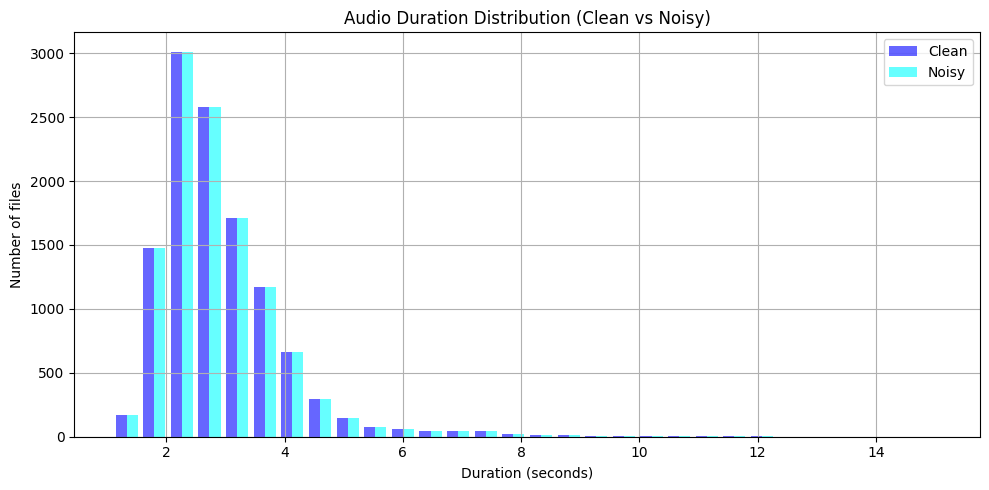

In [ ]:
def get_durations(audio_dir, sr=16000):
    durations = []
    for file_name in tqdm(os.listdir(audio_dir)):
        if file_name.endswith('.wav'):
            file_path = os.path.join(audio_dir, file_name)
            try:
                y, _ = librosa.load(file_path, sr=sr)
                durations.append(librosa.get_duration(y=y, sr=sr))
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    return durations

# Paths to your dataset
clean_path = os.path.join(dataset_path, "clean_trainset_28spk_wav")
noisy_path = os.path.join(dataset_path, "noisy_trainset_28spk_wav")

# Get durations
clean_durations = get_durations(clean_path)
noisy_durations = get_durations(noisy_path)

# Plotting
plt.figure(figsize=(10, 5))
plt.hist([clean_durations, noisy_durations], bins=30, label=['Clean', 'Noisy'], color=['blue', 'cyan'], alpha=0.6)
plt.title("Audio Duration Distribution (Clean vs Noisy)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of files")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The audio duration distribution shows that most clean and noisy files are short (2–4 seconds), with very few exceeding 6 seconds. The distribution is right-skewed, meaning there are fewer long audio samples.

**Comparing waveforms between noisy and clean audios**

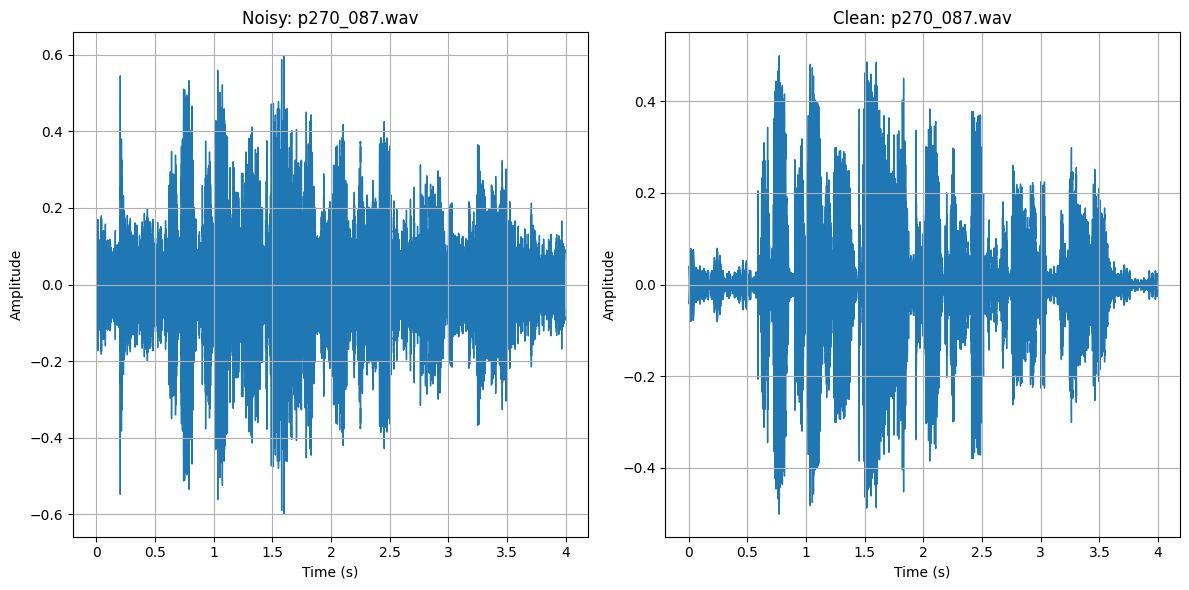

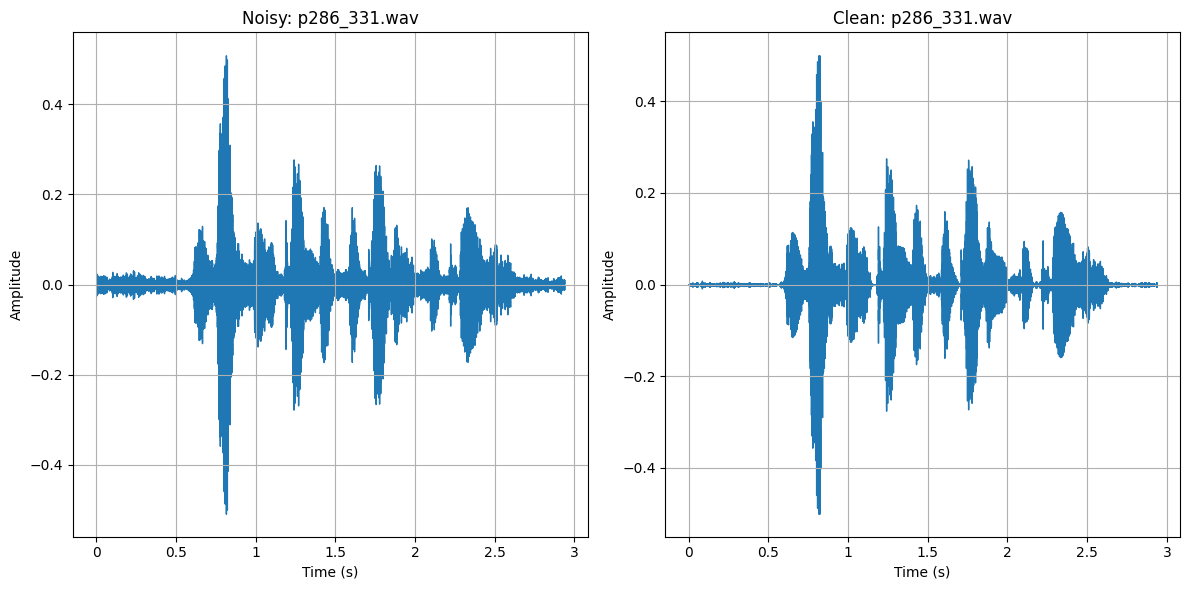

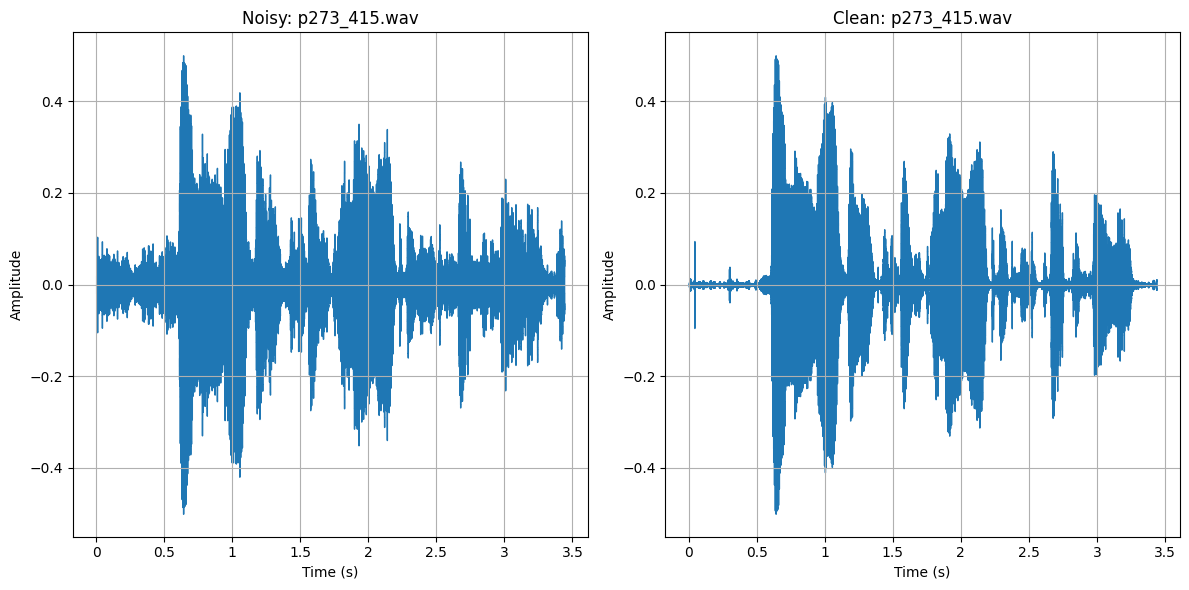

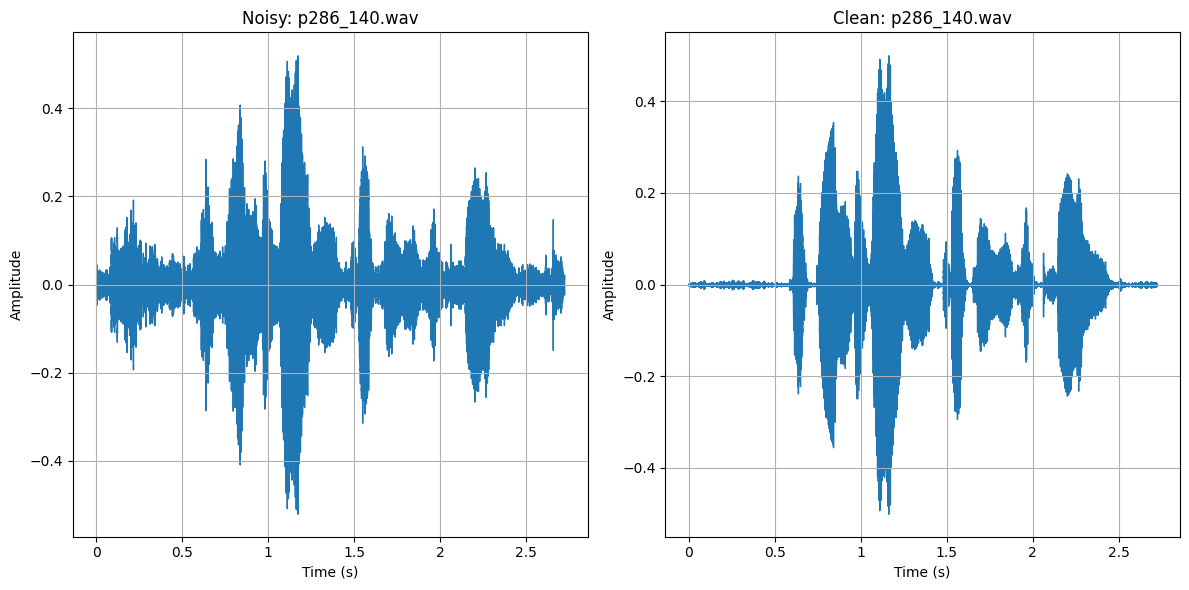

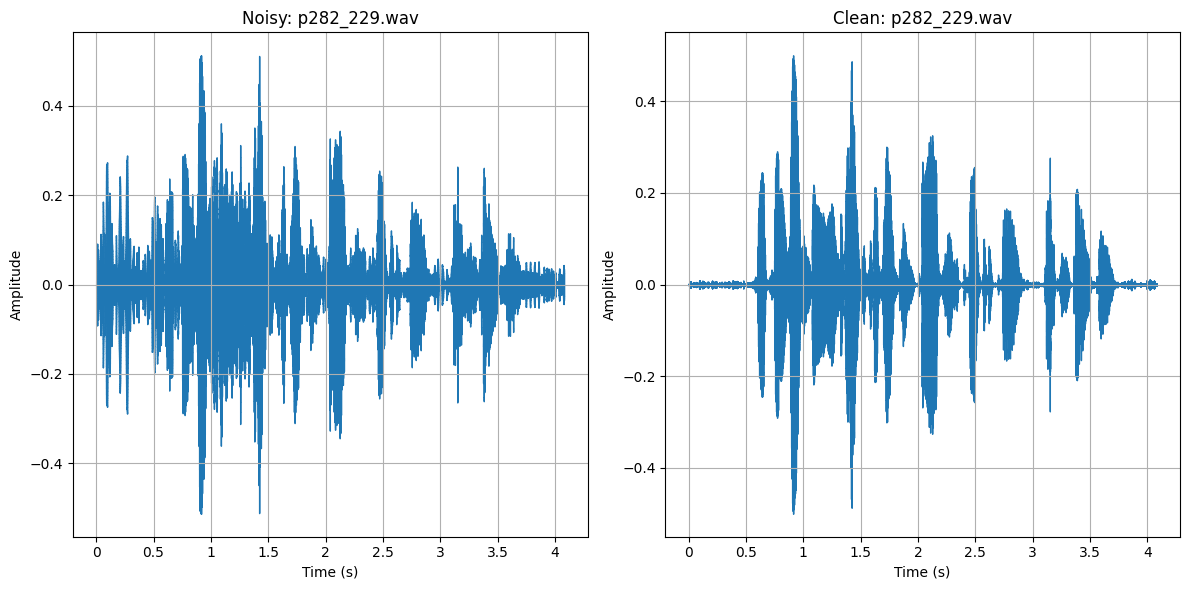

In [ ]:
for noisy_file, clean_file in zip(sample_noisy_files, sample_clean_files):
    noisy_file_path = os.path.join(dataset_path, "noisy_trainset_28spk_wav", noisy_file)
    clean_file_path = os.path.join(dataset_path, "clean_trainset_28spk_wav", clean_file)

    noisy_audio_data, sr_noisy = librosa.load(noisy_file_path, sr=None)
    clean_audio_data, sr_clean = librosa.load(clean_file_path, sr=None)

    plt.figure(figsize=(12, 6))

    # Plot the noisy waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(noisy_audio_data, sr=sr_noisy)
    plt.title(f"Noisy: {noisy_file}")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Plot the clean
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(clean_audio_data, sr=sr_clean)
    plt.title(f"Clean: {clean_file}")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

From the waveform comparison of noisy and clean audio signals, we observe that:
*   Noisy waveform: Dense and chaotic due to constant background noise.
*   Clean waveform: Clearer speech with visible silence and well-defined segments.

**Comparing Spectrograms between noisy and clean audios**

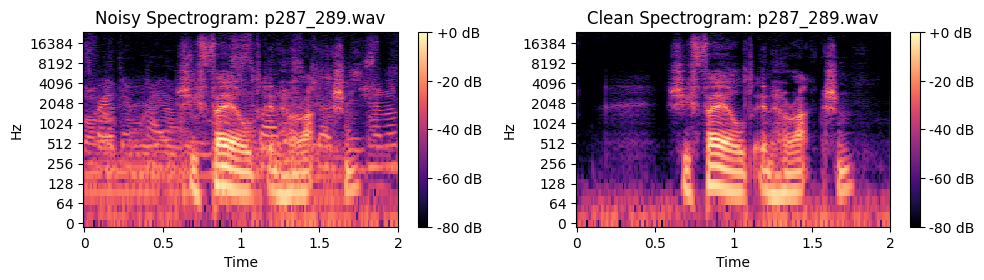

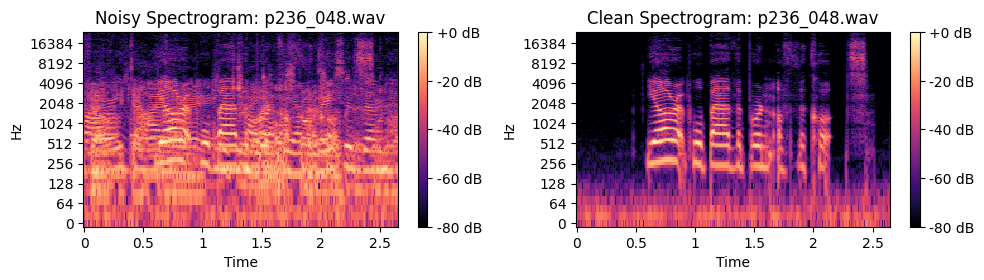

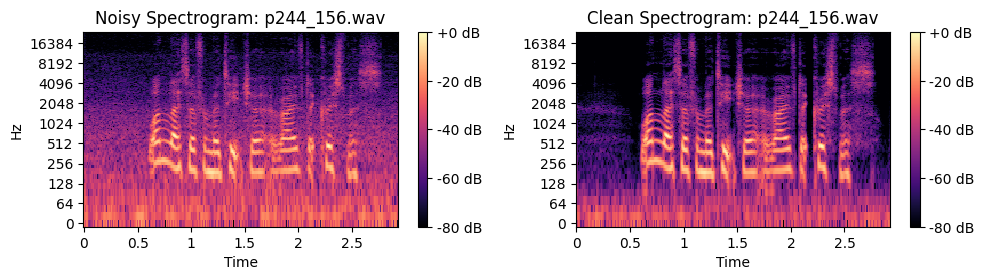

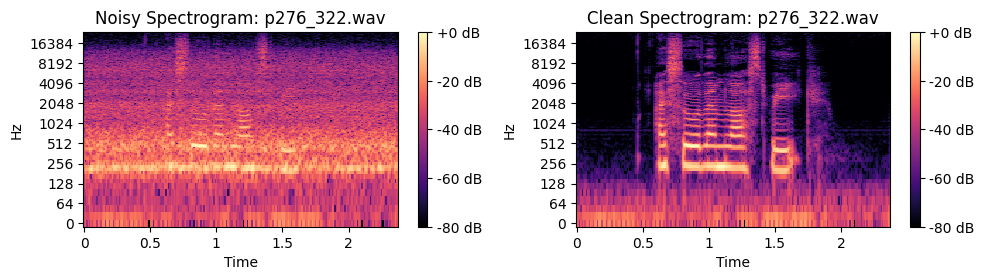

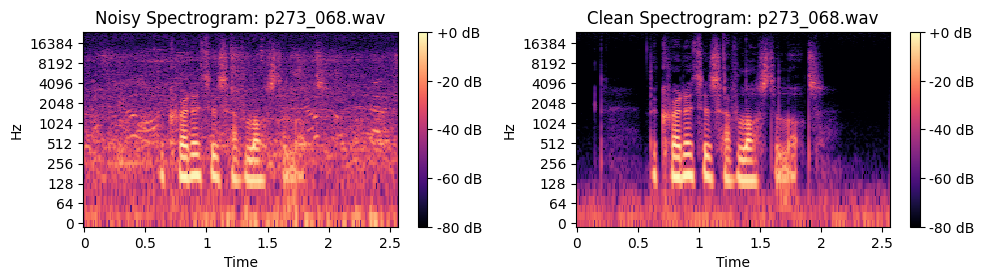

In [ ]:
for noisy_file, clean_file in zip(sample_noisy_files, sample_clean_files):

    noisy_file_path = os.path.join(dataset_path, "noisy_trainset_28spk_wav", noisy_file)
    clean_file_path = os.path.join(dataset_path, "clean_trainset_28spk_wav", clean_file)

    noisy_audio_data, sr_noisy = librosa.load(noisy_file_path, sr=None)
    clean_audio_data, sr_clean = librosa.load(clean_file_path, sr=None)

    # Compute spectrograms (Short-Time Fourier Transform)
    noisy_spectrogram = librosa.stft(noisy_audio_data)
    clean_spectrogram = librosa.stft(clean_audio_data)

    # Convert to dB scale
    noisy_db = librosa.amplitude_to_db(abs(noisy_spectrogram), ref=np.max)
    clean_db = librosa.amplitude_to_db(abs(clean_spectrogram), ref=np.max)

    plt.figure(figsize=(10, 5))

    # Plot the noisy spectrogram
    plt.subplot(2, 2, 1)
    librosa.display.specshow(noisy_db, sr=sr_noisy, x_axis="time", y_axis="log", cmap="magma")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Noisy Spectrogram: {noisy_file}")

    # Plot the clean spectrogram
    plt.subplot(2, 2, 2)
    librosa.display.specshow(clean_db, sr=sr_clean, x_axis="time", y_axis="log", cmap="magma")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Clean Spectrogram: {clean_file}")

    plt.tight_layout()
    plt.show()

These plots shows that clean spectrograms reveal speech patterns more distinctly, while noisy spectrograms exhibit blurred frequency content due to the added noise.

**Comparing waveforms before and after normalizing amplitudes to the range of [ -1, 1]**

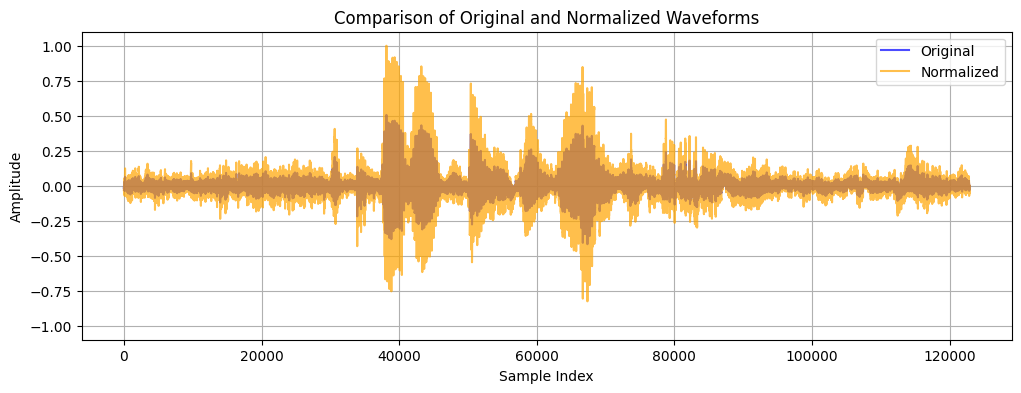

Original Audio:


Normalized Audio:


In [ ]:
import torchaudio
from IPython.display import Audio, display

def normalize_audio(audio):
    # Normalizes the audio amplitude to the range [-1, 1].
    max_val = audio.abs().max()
    if max_val > 0:
        return audio / max_val
    return audio

# Load an example audio file
audio_path = os.path.join(dataset_path, "noisy_trainset_28spk_wav", sample_noisy_files[4])
audio, sample_rate = torchaudio.load(audio_path)

# Normalize the audio
normalized_audio = normalize_audio(audio)

# plot the comparision of original and normalized waveforms
plt.figure(figsize=(12, 4))
plt.plot(audio.numpy().squeeze(), color='blue', label="Original", alpha=0.7)
plt.plot(normalized_audio.numpy().squeeze(), color='orange', label="Normalized", alpha=0.7)
plt.title("Comparison of Original and Normalized Waveforms")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.ylim(-1.1, 1.1)  # Fix y-axis range
plt.legend()
plt.grid(True)
plt.show()

# Listen to the original and normalized audio
print("Original Audio:")
display(Audio(audio.numpy().squeeze(), rate=sample_rate))

print("Normalized Audio:")
display(Audio(normalized_audio.numpy().squeeze(), rate=sample_rate))